# Retrieval

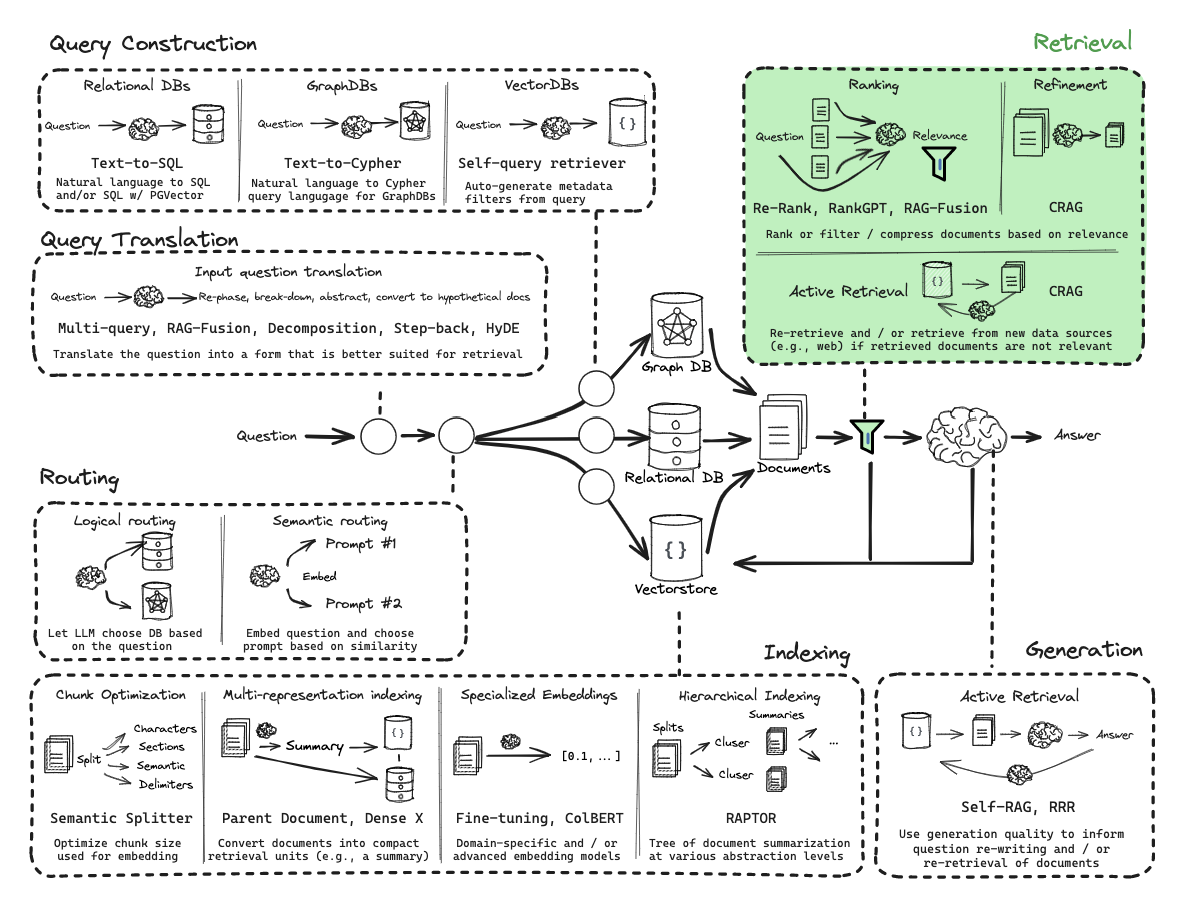

## Set Environment Vars and API Keys

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'advanced-rag'
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQQ_API_KEY")

## Re-ranking

### RAG-fusion

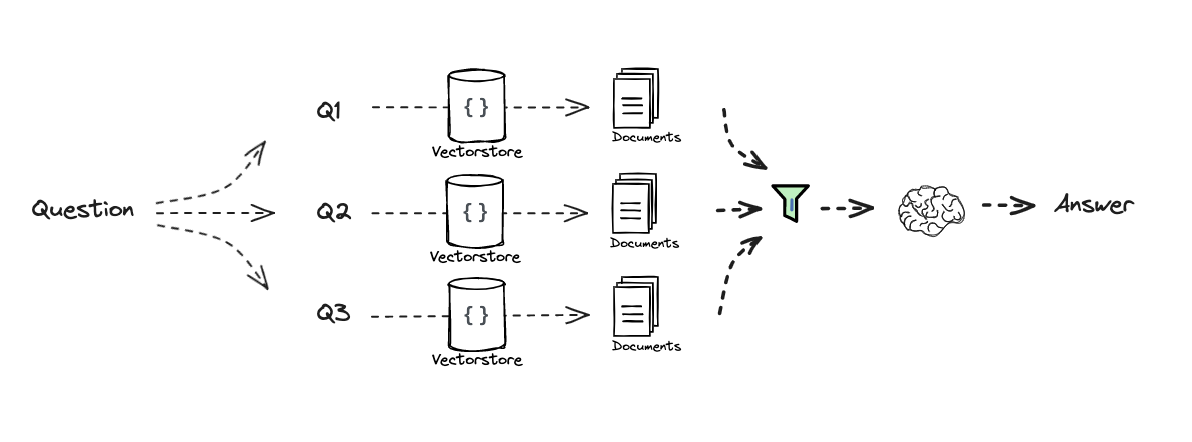

In [2]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=hf_embeddings)


retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
e:\Programs\anaconda3\envs\LLMs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

generate_queries = (
    prompt_rag_fusion 
    | ChatOllama(model = 'llama3.1',temperature=0)
    | StrOutputParser() 
    | (lambda x: [query.strip() for query in x.split("\n") if query.strip()])
)

In [5]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

question = "What is task decomposition for LLM agents?"
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

C:\Users\omark\AppData\Local\Temp\ipykernel_20392\788335263.py:26: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  (loads(doc), score)


13

In [6]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOllama(model = 'llama3.1',temperature=0)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM (Large Language Model) agents refers to breaking down complex tasks into smaller, more manageable sub-tasks that can be executed by the agent. This approach allows the agent to focus on one aspect of the task at a time, making it easier to complete and increasing the overall efficiency of the process.\n\nIn the context of LLMs, task decomposition is particularly useful when dealing with complex tasks that require multiple steps or involve interacting with external tools or APIs. By decomposing the task into smaller sub-tasks, the agent can:\n\n1. Focus on one aspect of the task at a time, reducing cognitive overload and increasing accuracy.\n2. Utilize specialized knowledge or skills to complete each sub-task, leveraging the strengths of the LLM.\n3. Interact with external tools or APIs in a more controlled and structured manner, minimizing errors and improving overall performance.\n\nTask decomposition is an essential aspect of prompt engineering for LLMs, 

###  Flash Re-Rank

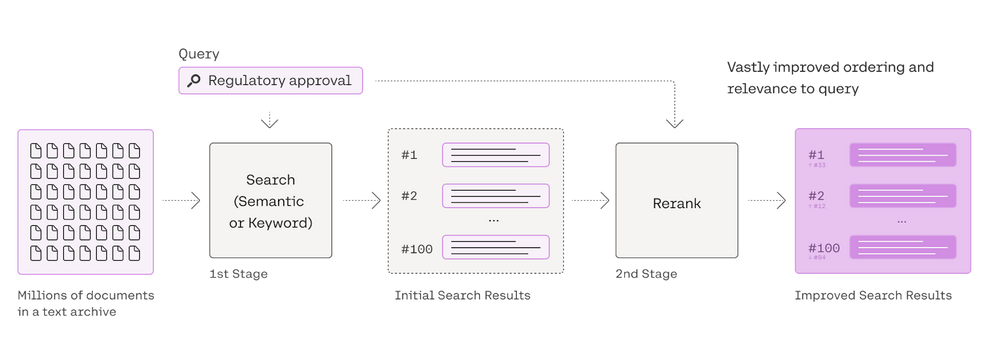

In [7]:
from langchain.retrievers import  ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from flashrank import Ranker, RerankRequest

retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

# Re-rank
ranker = Ranker(model_name="rank-T5-flan", cache_dir="/opt")
FlashrankRerank.update_forward_refs()
compressor = FlashrankRerank(client = ranker)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)



In [8]:
compressed_docs = compression_retriever.invoke(question)

### Ensemble Retriever

In [9]:
dense_retriever = retriever
dense_retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceBgeEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001EEB683E4B0>, search_kwargs={'k': 10})

In [10]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(splits)

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, dense_retriever], weights=[0.5, 0.5]
)

In [14]:
docs = ensemble_retriever.invoke(question)
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search

###  Long Context Reorder

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_community.document_transformers import (
    LongContextReorder,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
#from langchain_huggingface import HuggingFaceEmbeddings
# Get embeddings.
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Create a retriever
retriever = Chroma.from_documents(splits, embedding=embeddings).as_retriever(
    search_kwargs={"k": 10}
)
query = "What is task decomposition"

# Get relevant documents ordered by relevance score
docs = retriever.invoke(query)
docs

In [12]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)

# Confirm that the 4 relevant documents are at beginning and end.
reordered_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 2.  Examples of reasoning trajectories for knowledge-intensive tasks (e.g. HotpotQA, FEVER) and decision-making tasks (e.g. AlfWorld Env, WebShop). (Image source: Yao et al. 2023).\nIn both experiments on knowledge-intensive tasks and decision-making tasks, ReAct works better than the Act-only baseline where Thought: … step is removed.\nReflexion (Shinn & Labash 2023) is a framework to equips agents with dynamic memory and self-reflection capabilities to improve reasoning skills. Reflexion has a standard RL setup, in which the reward model provides a simple binary reward and the action space follows the setup in ReAct where the task-specific action space is augmented with language to enable complex reasoning steps. After each action $a_t$, the agent computes a heuristic $h_t$ and optionally may decide to reset the environment to start a new trial depending on the self-reflection re

### Self Querying / Metadata Retriever

In [13]:
from langchain_core.documents import Document

docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
]
vectorstore = Chroma.from_documents(docs, hf_embeddings)

In [14]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]
document_content_description = "Brief summary of a movie"
llm = ChatOllama(model = 'llama3.1',temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
)

In [15]:
# This example only specifies a filter
retriever.invoke("I want to watch a movie rated higher than 8.5")

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


[Document(metadata={'director': 'Satoshi Kon', 'rating': 8.6, 'year': 2006}, page_content='A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea'),
 Document(metadata={'director': 'Andrei Tarkovsky', 'genre': 'thriller', 'rating': 9.9, 'year': 1979}, page_content='Three men walk into the Zone, three men walk out of the Zone')]

In [ ]:
# This example specifies a query and a filter
retriever.invoke("Has Greta Gerwig directed any movies about women")

In [ ]:
# This example specifies a composite filter
retriever.invoke("What's a highly rated (above 8.5) science fiction film?")

## References

- [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25)